In [1]:
"""
1. Make a simple bigram model
2. Do a mlp model
2. Do a wavenet model
3. Do a GPT model
"""
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from dataclasses import dataclass
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from gpt.model import BiGram, MLP, WaveNet
from gpt.data import TextDataset
from gpt.wavenet_layers import make_wavenet
from gpt.utils import model_info, nan_hook
from torchinfo import summary
from gpt.transformer import Transformer

@torch.no_grad()
@torch.inference_mode()
def eval(device):
    losses = []
    for X, Y in iter(dl_val):
        X = X.to(device)
        Y = Y.to(device)
        y_logit, loss = model(X, Y)
        losses.append(loss.item())
    return torch.mean(torch.tensor(losses)).item()

In [8]:
batch_size=64
block_size=256

In [9]:
ds_train = TextDataset('input.txt','train', block_size=block_size)
ds_val = TextDataset('input.txt','val', block_size=block_size)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
vocab_size = len(ds_train.vocab)

In [10]:
c = Transformer.Config(block_size=block_size,
                       n_embd=384,
                       n_heads=6,
                       vocab_size=vocab_size,
                       n_blocks=6,
                       dropout=.2)
model = Transformer(c)
# model = MLP(vocab_size,block_size,n_embd, n_hidden)
# model = BiGram(vocab_size)
# _=summary(model, input_data=x,col_names=['input_size',"output_size", "num_params",'kernel_size'], verbose=2, row_settings=['var_names',], )

In [12]:
device = torch.device("cuda")
model = model.to(device)
# X,Y = next(iter(dl_train))
# X, Y = X.to(device),Y.to(device)
train_losses = []
val_losses = {}
step = 0

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
max_epochs = 20
eval_freq = 50
done = False
for epoch in range(1, max_epochs+1):
    for i, (X,Y) in enumerate(iter(dl_train), start=1):
        step += 1
        # break
        X = X.to(device)
        Y = Y.to(device)
        y_logit,loss = model(X, Y)
        
        # break
        
        optimizer.zero_grad(True)
        loss.backward()
        optimizer.step()
        # scheduler.step()
    
        if step == 0 or step % eval_freq == 0:
            val_loss = eval(device)
            val_losses[step] = val_loss
            lr = optimizer.param_groups[0]['lr']
            print(f'{epoch}:{i}|s={step} loss: {loss.item()} val_loss: {val_loss} lr: {lr}')
            
        train_losses.append(float(loss))
                
    print('epoch done')

1:50|s=50 loss: 2.5307457447052 val_loss: 2.548118829727173 lr: 0.0003
1:100|s=100 loss: 2.477017402648926 val_loss: 2.495133399963379 lr: 0.0003
1:150|s=150 loss: 2.4505116939544678 val_loss: 2.467078685760498 lr: 0.0003
1:200|s=200 loss: 2.4043378829956055 val_loss: 2.4465432167053223 lr: 0.0003
1:250|s=250 loss: 2.341930389404297 val_loss: 2.3758797645568848 lr: 0.0003
1:300|s=300 loss: 2.2527260780334473 val_loss: 2.304080009460449 lr: 0.0003
1:350|s=350 loss: 2.1582577228546143 val_loss: 2.2166993618011475 lr: 0.0003
1:400|s=400 loss: 2.0934464931488037 val_loss: 2.1583914756774902 lr: 0.0003
1:450|s=450 loss: 2.0401923656463623 val_loss: 2.1005845069885254 lr: 0.0003
1:500|s=500 loss: 1.9590400457382202 val_loss: 2.0557265281677246 lr: 0.0003
1:550|s=550 loss: 1.9203728437423706 val_loss: 2.019498586654663 lr: 0.0003
1:600|s=600 loss: 1.8934191465377808 val_loss: 1.9841663837432861 lr: 0.0003
1:650|s=650 loss: 1.8212238550186157 val_loss: 1.94488525390625 lr: 0.0003
1:700|s=700 l

In [14]:
# list(model.parameters())[0].var(0)

In [15]:
len(train_losses)

3599

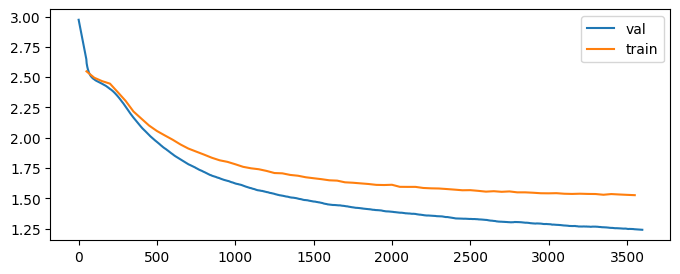

In [18]:
from scipy.signal import savgol_filter
train_losses_smoothed = savgol_filter(train_losses, 100, 1)
fig, ax = plt.subplots(1,1,figsize=(8,3))
i = list(range(0, len(train_losses), eval_freq))
ax.plot(train_losses_smoothed, label='val')
ax.plot(val_losses.keys(),val_losses.values(), label='train')
ax.legend()
# ax.set_

In [24]:
x = ds_val[0][0].unsqueeze(0).to(device)
y_pred = model.predict(x, 1000)
print(''.join(ds_train.decode(y_pred[0])))

nt.
That you cursed fare crosage too, stir
Your dreams both in a most nin-limp upon his,
O' heaven upon him; but ill my life away;
I go free, or enform'd his true.

MARCIUS:
Devotion, with blunk of thee.

BUCKINGHAM:
You now, being be my name for your importison.
What news! when liveral stonest disposed runces a
litterorious from to the day, you have again apreach
to peace his purpose.

Shepherd's tribank:
Faith, all all the service of Clarence.

HENRY BOLINGBROKE:
Now know me, Haste! by those I think, and I maake my way.

DUKE OF YORK:
What is, wert thou, my noble Backs,
This deady beat in his one by:
Thought it; if thou needstardy of Buckingham,
Mortal need, nor hunter fear to me.
If 'tell it were it down the words, or now,
My brothers lives grace for her neight, life,
look your fill.

BENVELIO:
Do it most dup will defusing,
As we stay in cumfone, the strumptures that
Lencther themself stranger, Rustolanus, Tyre-
O; Janon! father of now the warm love, maiden,
Which we may venture fro